**Лабораторная № 3. Пчелкина Ю.Ж. Двусторонняя фильтрация**

Задача

Для изображения размером MxN реализовать и применить версию CUDA 9-точечного двустороннего фильтра. Сохраните результат для вывода изображения. 
Недостающие значения для краевых строк и столбцов следует брать из ближайших пикселей. 
Реализация CUDA должна использовать texture memory

Входные данные: изображение в градациях серого в формате BMP

Выходные данные: 
- Время обработки изображения с помощью GPU;
- Время обработки изображения с помощью СPU;
- Полученные изображения в формате BMP.


In [1]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import math
import matplotlib.pyplot as plt

import cv2
import time
import datetime

In [2]:
from google.colab import files

In [3]:
uploaded = files.upload()

Saving cat.bmp to cat.bmp


считываем изображение

In [4]:
img1 = cv2.imread('cat.bmp')




d: Diameter of each pixel neighborhood.
sigmaColor: Value of \sigma  in the color space. The greater the value, the colors farther to each other will start to get mixed.
sigmaSpace: Value of \sigma  in the coordinate space. The greater its value, the more further pixels will mix together, given that their colors lie within the sigmaColor range.

**Двусторонняя фильтрация (с помощью служебной функции cv) на CPU**




Параметры bilateralFilter():
- d - Диаметр каждого пиксельного окружения
- sigmaColor - чем больше значение, тем ближе друг к другу цвета начнут смешиваться
- sigmaSpace - чем больше значение, тем больше пикселей будет смешиваться вместе, учитывая, что их цвета лежат в диапазоне sigmaColor



In [5]:
# по условию по 9 точкам, т.е. у каждого пиксела 8 соседей, т.е. d=1
d = 1
sigma_сolor = 1000
sigma_space = 1000

In [20]:
# отметили стартовое время
start_time = datetime.datetime.now()

bil_img1 = cv2.bilateralFilter(img1, d, sigma_сolor, sigma_space)

# посчитали затраченное время
t1 = datetime.datetime.now() - start_time
print ('time:  '+ str(t1)) 

time:  0:00:00.004950


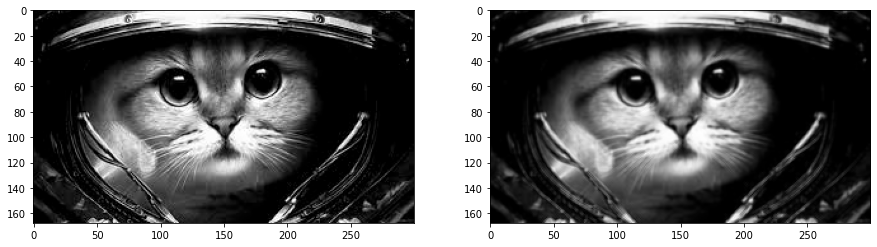

In [97]:
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.subplot(1, 2, 2)
plt.imshow(bil_img1)

In [102]:
# Сохраняем
cv2.imwrite('bil_1.bmp', bil_img1)

True

**Двусторонняя фильтрация (собственная реализация метода) на CPU**

Делала по формулам из методички, но что-то результат отличается от OpenCv.

In [9]:
img1_copy = img1.copy()

In [10]:
img1.shape, img1_copy.shape

((168, 300, 3), (168, 300, 3))

In [12]:
def bilaterial (image, image_copy, sigma_сolor, sigma_space):
  
  # пробегаем по всему массиву точек с координатами (x,y), кроме граничных точек
  for x in range(1, image_copy.shape[0] - 1):
    for y in range(1, image_copy.shape[1] - 1):
      # интенсивность пикселей
      sum_h = 0
      # нормализующая константа для предотвращения увеличения интенсивности
      sum_k = 0
      
      # для каждого пиксела новые значения получаем в зависимости от "соседей"
      for i in range(x-1, x+2):
        for j in range(y-1, y+2):
          
          # коэффициент, зависящий от расстояния до центрального пикселя          
          x2 = (i - x)**2
          y2 = (j - y)**2
          e = np.exp((x2 - y2)/(sigma_space**2))
          g = 1/e

          # функция расчета новой интенсивности без нормирующих коэффициентов
          f_ai = image[i, j]
          f_a0 = image[x,y]
          r = np.exp( ((f_ai - f_a0)**2)/ (sigma_сolor**2))

          sum_k += g*r
          sum_h += g*r*image[i, j]
         

      # заменяем пиксель в копии изображения на новый 
      image_copy[x, y] = sum_h / sum_k

  # значения для краевых строк и столбцов берем из ближайших пикселей

  for x in range(0, image.shape[0]):
    image_copy[x,0]=image[x,1]
    image_copy[x,image.shape[1]-1]=image[x,image.shape[1]-2]
        
  for y in range(0, image.shape[1]):
    image_copy[0,y]=image[1,y]
    image_copy[image.shape[0]-1,y]=image[image.shape[0]-2,y] 
  
  return image_copy


In [69]:
# отметили стартовое время
start_time = datetime.datetime.now()

bil_img2 = bilaterial (img1, img1_copy, sigma_сolor, sigma_space)

# посчитали затраченное время
t2 = datetime.datetime.now() - start_time
print ('time:  '+ str(t2)) 

time:  0:00:09.976678


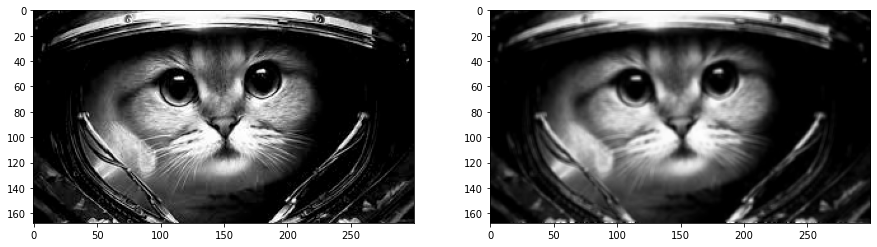

In [70]:
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.subplot(1, 2, 2)
plt.imshow(bil_img2)

In [103]:
# Сохраняем
cv2.imwrite('bil_2.bmp', bil_img2)

True

**Двусторонняя фильтрация на GPU**

Обработка изображений на графических процессорах.
- большинство операций обработки изображений представляют собой некоторые вычисления с использованием текущего значения пикселя, вычисления повторяются для каждого пикселя и уже итог записывается в выходное изображение. Очевидно, что это можно сделать одновременно (параллельно) для каждого пикселя, поскольку выходные значения не зависят друг от друга.

- при обработке изображений нужен быстрый доступ к значениям пикселей. Графические процессоры предназначены для графических целей, и одним из них является текстурирование, поэтому аппаратное обеспечение для доступа и управления пикселями хорошо оптимизировано. 




Предлагаемый метод

1. Скопируйте входные данные в память устройства;
2. Привязать входные данные к ссылке на текстуру;
3. Извлечь каждый пиксель вместе с окружающими его пикселями через память текстур в массив из 9 элементов;
4. Рассчитайте интенсивность пикселей результата, используя приведенные выше формулы;
5. Сохраните результат в массиве.


!!! Реализация CUDA должна использовать texture memory

In [22]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 4.5 MB/s 
     |████████████████████████████████| 66 kB 4.0 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627070 sha256=64b630a081325aee7bd4ca2e78788ea242b7d56075e407e864efe0df05c2f3e7
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=d4210f2bd1a05349531575164fb445bf16175a1568d40b2e1150ccee2b023f35
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


In [72]:
from pycuda import driver, compiler
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [73]:
# texture memory

BilateralGPU = SourceModule("""
texture<unsigned int, 2, cudaReadModeElementType> tex;
__global__ void BilateralGPU(unsigned int* result, const int M, const int N, const float sigma_d, const float sigma_r){
  
  const int i = threadIdx.x + blockDim.x * blockIdx.x;
  const int j = threadIdx.y + blockDim.y * blockIdx.y;
  
  if ((i < M) && (j < N)) {
    float s = 0;
    float c = 0;
    
    for (int l = i - 1; l <= i + 1; l++){
      for (int k = j - 1; k <= j + 1; k++){
        float f1 = tex2D(tex, k, l) / 255;
        float f2 = tex2D(tex, i, j) / 255;
        float g = exp(-(pow(k - i, 2) + pow(l - j, 2)) / pow(sigma_d, 2));
        float r = exp(-pow((f1 - f2) * 255, 2) / pow(sigma_r, 2));
        c += g * r;
        s += g * r * tex2D(tex, k, l);
      }
    }
    result[i * N + j] = s / c;
  }
}
""")

BilateralFilteringGPU = BilateralGPU.get_function("BilateralGPU")

In [74]:
img1.shape

(168, 300, 3)

В другом формате считаем картинку (размер M*N)

In [75]:
img2 = cv2.imread('cat.bmp', cv2.IMREAD_GRAYSCALE)
img2.shape

(168, 300)

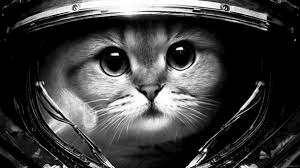

In [76]:
from google.colab.patches import cv2_imshow
cv2_imshow(img2)

In [77]:
M = img2.shape[0]
N = img2.shape[1]
block = (16, 16, 1)

grid = (int(np.ceil(M/block[0])),int(np.ceil(N/block[1])))

In [78]:
BilateralFilteringGPU
sigma_сolor = 1000
sigma_space = 1000

In [79]:
# отметили стартовое время
start_time = datetime.datetime.now()

#Копируем данные в текстуру
textur = BilateralGPU.get_texref("tex")
textur.set_filter_mode(pycuda.driver.filter_mode.LINEAR)
textur.set_address_mode(0, pycuda.driver.address_mode.MIRROR)
textur.set_address_mode(1, pycuda.driver.address_mode.MIRROR)
pycuda.driver.matrix_to_texref(img2.astype(np.uint32), textur, order="C")

#Запускаем функцию ядра

bil_img3 = np.zeros((img2.shape[0], img2.shape[1]), dtype = np.uint32)

BilateralFilteringGPU(driver.Out(bil_img3), 
       np.int32(M), np.int32(N), 
       np.float32(sigma_сolor),
       np.float32(sigma_space),
       texrefs=[textur], 
       block=(block[0], block[1], 1), 
       grid=grid)

t3 = datetime.datetime.now() - start_time
print ('time:  '+ str(t2)) 

time:  0:00:09.976678


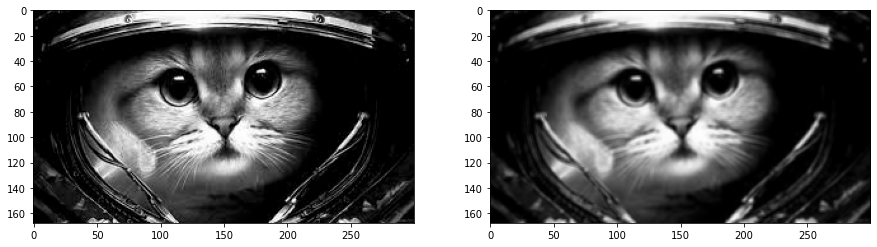

In [80]:
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.subplot(1, 2, 2)
plt.imshow(bil_img3, cmap=plt.cm.gist_gray)


In [105]:
# Сохраняем
cv2.imwrite('bil_3.bmp', bil_img3.astype(np.uint8))

True

In [85]:
print("время работы на CPU (служебная функция): ", t1)
print("время работы на CPU (собственная реализация): ", t2)
print("время работы на GPU: ", t3)
print("ускорение (служебная функция) : ", t1/t3)
print("ускорение (собственная реализация) : ", t2/t3)

время работы на CPU (служебная функция):  0:00:00.004950
время работы на CPU (собственная реализация):  0:00:09.976678
время работы на GPU:  0:00:00.002867
ускорение (служебная функция) :  1.7265434251831182
ускорение (собственная реализация) :  3479.831880013952
